In [1]:
# update the polars package - optional
# !pip install --upgrade polars

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import sys
import polars as pl

# Add the hamilton module to your path - optinal
# project_dir = "### ADD PATH HERE ###"
# sys.path.append(project_dir)

from hamilton import base, driver
from hamilton.io.materialization import to

In [4]:
# We use the autoreload extension that comes with ipython to automatically reload modules when
# the code in them changes.

# import the jupyter extension
%load_ext autoreload
# set it to only reload the modules imported
%autoreload 1

In [5]:
%%writefile spend_calculations.py
# Define your new Hamilton functions.
# The %%writefile magic command creates a new Python module with the functions below.
# We will import this later and pass it into our Driver.

import polars as pl

# Look at `my_functions` to see how these functions connect.
def avg_3wk_spend(spend: pl.Series) -> pl.Series:
    """Rolling 3 week average spend."""
    return spend.rolling_mean(3)


def spend_per_signup(spend: pl.Series, signups: pl.Series) -> pl.Series:
    """The cost per signup in relation to spend."""
    return spend / signups


def spend_mean(spend: pl.Series) -> float:
    """Shows function creating a scalar. In this case it computes the mean of the entire column."""
    return spend.mean()


def spend_zero_mean(spend: pl.Series, spend_mean: float) -> pl.Series:
    """Shows function that takes a scalar. In this case to zero mean spend."""
    return spend - spend_mean


def spend_std_dev(spend: pl.Series) -> float:
    """Function that computes the standard deviation of the spend column."""
    return spend.std()


def spend_zero_mean_unit_variance(spend_zero_mean: pl.Series, spend_std_dev: float) -> pl.Series:
    """Function showing one way to make spend have zero mean and unit variance."""
    return spend_zero_mean / spend_std_dev

Overwriting spend_calculations.py


In [6]:
initial_columns = {  # load from actuals or wherever -- this is our initial data we use as input.
    # Note: these values don't have to be all series, they could be a scalar.
    "signups": pl.Series([1, 10, 50, 100, 200, 400]),
    "spend": pl.Series([10, 10, 20, 40, 40, 50]),
}

In [7]:
%aimport spend_calculations

df_builder = base.PandasDataFrameResult()
dr = driver.Driver({}, spend_calculations)  # can pass in multiple modules

Note: Hamilton collects completely anonymous data about usage. This will help us improve Hamilton over time. See https://github.com/dagworks-inc/hamilton#usage-analytics--data-privacy for details.


In [8]:
# we need to specify what we want in the final dataframe. These can be string names, or function references.
output_columns = [
    "spend",
    "signups",
    "avg_3wk_spend",
    "spend_per_signup",
    "spend_zero_mean_unit_variance",
]

In [9]:
# pass

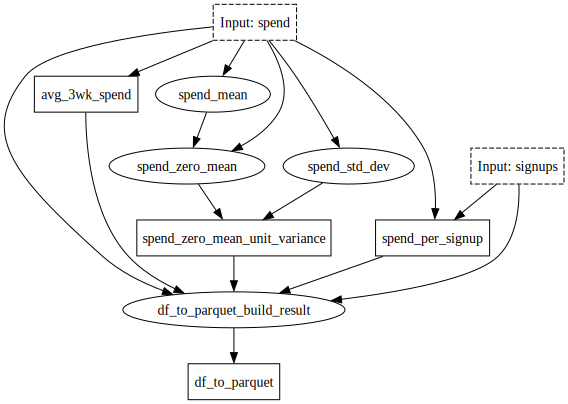

In [11]:
materializers = [
    # materialize the dataframe to a parquet file
    to.parquet(
        dependencies=output_columns,
        id="df_to_parquet",
        path="./df.parquet",
        combine=df_builder,
    ),
]
# Visualize what is happening
dr.visualize_materialization(
    *materializers,
    additional_vars=output_columns,
    inputs=initial_columns,
)

In [12]:
# Materialize a result, i.e. execute the DAG!
materialization_results, additional_outputs = dr.materialize(
    *materializers,
    additional_vars=[
        "df_to_parquet_build_result",
    ],  # because combine is used, we can get that result here.
    inputs=initial_columns,
)

It appears no Pandas index type was detected (ignore this warning if you're using DASK for now.) Please check whether the dataframe created matches what what you expect to happen.
/Users/stefankrawczyk/.pyenv/versions/3.9.13/envs/hamilton-ray-py39/lib/python3.9/site-packages/pyarrow/pandas_compat.py:358: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


In [13]:
materialization_results

{'df_to_parquet': {'size': 4703,
  'path': './df.parquet',
  'last_modified': 1696451975.2548041,
  'timestamp': 1696477175.255047}}

In [14]:
additional_outputs["df_to_parquet_build_result"]

,spend,signups,avg_3wk_spend,spend_per_signup,spend_zero_mean_unit_variance
0,10,1,NaN,10.000,-1.064405
1,10,10,NaN,1.000,-1.064405
2,20,50,13.333333,0.400,-0.483821
3,40,100,23.333333,0.400,0.677349
4,40,200,33.333333,0.200,0.677349
5,50,400,43.333333,0.125,1.257934


In [ ]:
#pass